In [77]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

import pandas as pd
import numpy as np

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/85567/_3afd3252820d8a4e1c5c9148bb0ec3a5_bike_sharing_demand.csv', header=0, sep=',')

In [80]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [81]:
data.datetime = data.datetime.apply(pd.to_datetime)
data['month'] = data.datetime.apply(lambda x : x.month)
data['hour'] = data.datetime.apply(lambda x : x.hour)

In [82]:
train_data = data[:-1000]
test_data = data[-1000:]

print(train_data.shape, test_data.shape)

train_labels = train_data['count']
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

test_labels = test_data['count']
test_data = test_data.drop(['datetime', 'count', 'casual', 'registered'], axis=1)

(9886, 14) (1000, 14)


In [83]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype=bool)

In [84]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [85]:
categorical_data_columns = ['season', 'weather', 'month']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype=bool)

In [86]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [87]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype=bool)

In [88]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


In [103]:
regressor = linear_model.SGDRegressor(random_state=0, max_iter=3, loss='squared_loss', penalty='l2')

In [107]:
estimator = pipeline.Pipeline(steps = [
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [
        
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])),
        
        ('numeric_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean=0.0))
        ])),
        
        ('categorical_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
        ]))
        
        
    ])),
    ('model_fitting', regressor)
])

In [108]:
estimator.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x000001F0B90CE0D0>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001F0B90CE280>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0.0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001F0B

In [109]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.17177172806856

In [115]:
print(*estimator.get_params().keys(), sep='\n')

memory
steps
verbose
feature_processing
model_fitting
feature_processing__n_jobs
feature_processing__transformer_list
feature_processing__transformer_weights
feature_processing__verbose
feature_processing__binary_variables_processing
feature_processing__numeric_variables_processing
feature_processing__categorical_variables_processing
feature_processing__binary_variables_processing__accept_sparse
feature_processing__binary_variables_processing__check_inverse
feature_processing__binary_variables_processing__func
feature_processing__binary_variables_processing__inv_kw_args
feature_processing__binary_variables_processing__inverse_func
feature_processing__binary_variables_processing__kw_args
feature_processing__binary_variables_processing__validate
feature_processing__numeric_variables_processing__memory
feature_processing__numeric_variables_processing__steps
feature_processing__numeric_variables_processing__verbose
feature_processing__numeric_variables_processing__selecting
feature_process

In [118]:
parameters_grid = {
    'model_fitting__alpha': [0.0001, 0.001, 0.1],
    'model_fitting__eta0': [0.001, 0.05]
}

In [123]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring='neg_mean_absolute_error', cv=4)

In [124]:
grid_cv.fit(train_data, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\A

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\ProgramData\A

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000001F0B90CE0D0>)),
                                                                       ('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x000001F0B90CE280>)),
                                                                                        ('scaling',
                                                                                         StandardScaler(wit...
                                                                        Pipeline(steps=[('selectin

In [122]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [125]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-104.61466553476612
{'model_fitting__alpha': 0.1, 'model_fitting__eta0': 0.05}


In [126]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [127]:
metrics.mean_absolute_error(test_labels, test_predictions)

126.17670701473044

In [130]:
print(list(test_labels[:20]))

[525, 835, 355, 222, 228, 325, 328, 308, 346, 446, 943, 838, 531, 432, 195, 181, 199, 49, 17, 16]


In [132]:
print([round(x, 2) for x in test_predictions[:20]])

[143.24, 166.19, 212.42, 243.67, 262.21, 255.96, 280.36, 307.47, 313.16, 323.56, 320.61, 313.13, 294.67, 279.5, 269.68, 240.32, 244.88, 52.83, 60.38, 67.93]


In [133]:
from sklearn.ensemble import RandomForestRegressor

In [134]:
rg = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=50)

In [135]:
estimator_rg = pipeline.Pipeline(steps = [
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [
        
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])),
        
        ('numeric_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean=0.0))
        ])),
        
        ('categorical_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorical_data_indices])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
        ]))
        
        
    ])),
    ('model_fitting', rg)
])

In [141]:
estimator_rg.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x000001F0BA7F0280>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001F0BA8DF1F0>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0.0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000001F0B

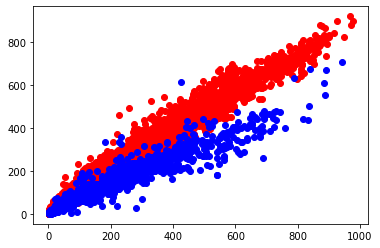

In [143]:
plt.scatter(train_labels, estimator_rg.predict(train_data), color='red')
plt.scatter(test_labels, estimator_rg.predict(test_data), color='blue')